In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import os

In [ ]:
data = pd.read_csv('/content/TELANGANA.csv')
print(data.isna().sum())

YEAR      0
ANNUAL    0
dtype: int64


In [ ]:
data = data.dropna()

In [ ]:
print(data.describe())

              YEAR       ANNUAL
count   115.000000   115.000000
mean   1958.000000   953.378261
std      33.341666   205.925999
min    1901.000000   437.000000
25%    1929.500000   800.150000
50%    1958.000000   942.100000
75%    1986.500000  1080.300000
max    2015.000000  1544.900000


In [ ]:
figure = px.line(data, x="YEAR",
                 y="ANNUAL",
                 title='Annual Rainfall(Bihar)')
figure.show()

In [ ]:
# data["YEAR"] = pd.to_datetime(data["YEAR"], format = '%Y-%m-%d')
# data['Year'] = data['YEAR'].dt.year
# data["Month"] = data["YEAR"].dt.month
# print(data.head())

import pandas as pd

# Assuming 'data' is your DataFrame
data["YEAR"] = pd.to_datetime(data["YEAR"], format='%Y-%m-%d')
data['Year'] = data['YEAR'].dt.year % 100  # Extracting last two digits of the year
data["Month"] = data["YEAR"].dt.month
print(data.head())



                           YEAR  ANNUAL  Year  Month
0 1970-01-01 00:00:00.000001901   827.7    70      1
1 1970-01-01 00:00:00.000001902   630.4    70      1
2 1970-01-01 00:00:00.000001903  1283.4    70      1
3 1970-01-01 00:00:00.000001904   526.7    70      1
4 1970-01-01 00:00:00.000001905   724.9    70      1


<Figure size 640x480 with 0 Axes>

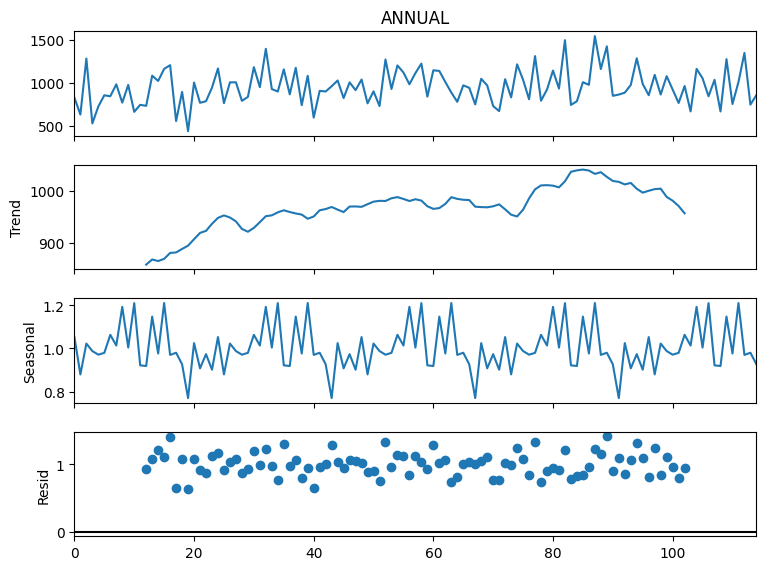

In [ ]:
data["ANNUAL"] = data["ANNUAL"] + 0.01

result = seasonal_decompose(data["ANNUAL"], model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

In [ ]:
model = auto_arima(data['ANNUAL'], seasonal=True, m=52, suppress_warnings=True)
print(model.order)

(4, 1, 1)


In [ ]:
data

,YEAR,ANNUAL,Year,Month
0,1970-01-01 00:00:00.000001901,554.31,70,1
1,1970-01-01 00:00:00.000001902,863.91,70,1
2,1970-01-01 00:00:00.000001903,887.61,70,1
3,1970-01-01 00:00:00.000001904,492.61,70,1
4,1970-01-01 00:00:00.000001905,811.51,70,1
...,...,...,...,...
110,1970-01-01 00:00:00.000002011,890.51,70,1
111,1970-01-01 00:00:00.000002012,714.01,70,1
112,1970-01-01 00:00:00.000002013,1118.61,70,1
113,1970-01-01 00:00:00.000002014,705.71,70,1


In [ ]:
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Assuming 'data' is a pandas DataFrame and 'ANNUAL' is the column with time series data
data = data

# Define the p, d, q parameters to take any value from 0 to 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define the seasonal p, d, q parameters to take any value from 0 to 2 and set the seasonal period to 52 weeks
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

# Split data into train and test sets
train_data = data["ANNUAL"].iloc[:-12]
test_data = data["ANNUAL"].iloc[-12:]

# Define a function to fit SARIMAX model and compute the AIC
def sarimax_grid_search(data, pdq, seasonal_pdq):
    best_aic = float('inf')
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(data,
                                order=param,
                                seasonal_order=seasonal_param,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

                results = model.fit()

                # Compare this model's AIC with the best AIC found so far
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = seasonal_param
                    best_model = results
            except:
                continue

    return best_aic, best_pdq, best_seasonal_pdq, best_model

# Run the grid search
best_aic, best_pdq, best_seasonal_pdq, best_model = sarimax_grid_search(train_data, pdq, seasonal_pdq)

# Print the results
print(f'Best SARIMAX model: order={best_pdq} seasonal_order={best_seasonal_pdq} AIC={best_aic}')

# Predict on the test set
predictions = best_model.get_forecast(steps=12)
predicted_mean = predictions.predicted_mean

# Compute the mean squared error
mse = mean_squared_error(test_data, predicted_mean)
print(f'Test MSE: {mse}')


In [ ]:
# from statsmodels.tools.sm_exceptions import  ValueWarning
# warnings.simplefilter('ignore', ValueWarning)

p, d, q = 4,1,1

model = SARIMAX(data["ANNUAL"], order=(p, d, q),
                seasonal_order=(p, d, q, 52))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



                                     SARIMAX Results                                      
Dep. Variable:                             ANNUAL   No. Observations:                  115
Model:             SARIMAX(4, 1, 1)x(4, 1, 1, 52)   Log Likelihood                -429.962
Date:                            Sat, 20 Jan 2024   AIC                            881.924
Time:                                    21:03:54   BIC                            905.323
Sample:                                         0   HQIC                           891.111
                                            - 115                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3273      0.267     -1.224      0.221      -0.851       0.197
ar.L2         -0.1150      0.302   

In [ ]:
# Use the same number of steps in both cases
steps = 200

# Generate the range of years starting from 1901
forecast_years = range(1901, 1901 + steps)

# Create a new DataFrame with the predicted values and the corresponding years
predictions_df = pd.DataFrame({'YEAR': forecast_years, 'ANNUAL': fitted.get_forecast(steps=steps).predicted_mean.values})

# Set the 'YEAR' column as the index
predictions_df.set_index('YEAR', inplace=True)

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv')

print(predictions_df)


           ANNUAL
YEAR             
1901   746.259120
1902   665.353724
1903  1076.719314
1904   919.206913
1905   869.876808
...           ...
2096  1084.437579
2097   964.204418
2098  1312.831846
2099  1188.137162
2100  1373.633011

[200 rows x 1 columns]


In [ ]:
# predictions = fitted.predict(len(data), len(data)+200)
# print(predictions)

# # Generate the range of years starting from 1901
# forecast_years = range(1901, 1901 + 90)

# # Create a new DataFrame with the predicted values and the corresponding years
# predictions_df = pd.DataFrame({'YEAR': forecast_years, 'ANNUAL': fitted.get_forecast(steps=200).predicted_mean.values})

# # Set the 'YEAR' column as the index
# predictions_df.set_index('YEAR', inplace=True)

# print(predictions_df)


# # forecast_years = range(data["YEAR"].max().year + 1, data["YEAR"].max().year + 91)
# # forecast_index = pd.Index(forecast_years, name='YEAR')
# # predictions = pd.Series(fitted.get_forecast(steps=90).predicted_mean.values, index=forecast_index, name='ANNUAL')
# # print(predictions)

# Use the same number of steps in both cases
steps = 90  # Adjust the number of steps based on your requirement

# Generate the range of years starting from 1901
forecast_years = range(1901, 1901 + steps)

# Create a new DataFrame with the predicted values and the corresponding years
predictions_df = pd.DataFrame({'YEAR': forecast_years, 'ANNUAL': fitted.get_forecast(steps=steps).predicted_mean.values})

# Set the 'YEAR' column as the index
predictions_df.set_index('YEAR', inplace=True)

print(predictions_df)


           ANNUAL
YEAR             
1901  1007.007295
1902  1057.593866
1903   765.952539
1904  1007.818469
1905  1150.781600
...           ...
1986  1096.945792
1987  1172.356627
1988  1094.179762
1989  1064.897318
1990  1142.906165

[90 rows x 1 columns]


In [ ]:
fig = go.Figure()

# Add training data line plot
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['ANNUAL'],
    mode='lines',
    name='Training Data',
    line=dict(color='blue')
))

# Add predictions line plot
fig.add_trace(go.Scatter( x=predictions_df.index, y=predictions_df, mode='lines',
    name='Predictions',
    line=dict(color='red')
    ))

fig.update_layout(
    title="Training Data VS Predictions",
    xaxis_title="YEAR",
    yaxis_title="ANNUAL",
    legend_title="Data",
    width=1000,
    height=600
)

pio.show(fig)

In [ ]:
model

In [ ]:
fitted

In [ ]:
import pickle
Pkl_Filename = "/content/model.pkl"

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(fitted, file)

In [ ]:
with open(Pkl_Filename, 'rb') as file:
    saved_model = pickle.load(file)

print(saved_model)

In [ ]:
saved_model.predict(len(data), len(data)+200)

115    1007.015556
116    1057.901908
117     766.098066
118    1007.994982
119    1150.969285
          ...     
311     800.161994
312     664.618723
313     735.962653
314     931.701012
315     918.277224
Name: predicted_mean, Length: 201, dtype: float64

In [ ]:
!pip install streamlit
!pip install folium